# Neural Networks for Classification

In this notebook I will explore neural networks in a similar manner to how i did in the notebook on logistic regression. 

## Data Preprocessing

### Data Loading

In [1]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import sklearn  # Machine learning library
from sklearn.neural_network import MLPClassifier  # Neural network implementation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # For model evaluation
import seaborn as sns  # For enhanced visualizations
import matplotlib.pyplot as plt  # For plotting
from typing import List, Tuple  # Import type hints for better code clarity
from sklearn.feature_selection import chi2  # For feature selection using chi-squared test

# Define feature lists for preprocessing
# Categorical features that will need one-hot encoding
categorical_features: List[str] = ["proto", "state", "service", "is_sm_ips_ports", "is_ftp_login"]
# Numerical features that will undergo log transformation to handle skewness
features_to_transform: List[str] = [
    'sbytes', 'dbytes', 'sttl', 'dttl', 'sload', 'dload', 'spkts', 'dpkts', 
    'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'sjit', 'djit'
]

# ----- DATA LOADING AND CLEANING -----

# Load the UNSW-NB15 cybersecurity dataset (split into training and testing sets)
train_data: pd.DataFrame = pd.read_csv('../data/UNSW_NB15/UNSW_NB15_training-set.csv')
test_data: pd.DataFrame = pd.read_csv('../data/UNSW_NB15/UNSW_NB15_testing-set.csv')

# Remove unnecessary columns:
# - 'attack_cat': specific attack category (we're doing binary classification)
# - 'id': identifier column that doesn't contribute to the model
columns_to_drop = ['attack_cat', 'id']
for df in [train_data, test_data]:
    for col in columns_to_drop:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)

# ----- FEATURE PROCESSING FUNCTIONS -----

def process_numeric_features(df: pd.DataFrame, features: List[str]) -> pd.DataFrame:
    """
    Apply log transformation to numeric features to normalize distributions.
    
    This helps handle skewed data and extreme values that are common in network traffic features.
    The log1p function (log(x+1)) is used to safely handle zero values.
    
    Args:
        df: DataFrame containing the features
        features: List of numeric feature names to transform
        
    Returns:
        DataFrame with transformed features
    """
    for feature in features:
        if feature in df.columns:
            df[feature] = np.log1p(df[feature])  # log(x+1) to handle zeros
    print("Log transformation applied to numeric features (if present) in the dataset")
    return df

def process_categorical_features(df: pd.DataFrame, cat_features: List[str]) -> Tuple[pd.DataFrame, List[str]]:
    """
    One-hot encode categorical features and return updated dataframe with new column names.
    
    This converts categorical variables into binary columns, which is necessary for neural networks
    that can only work with numerical inputs.
    
    Args:
        df: DataFrame containing the features
        cat_features: List of categorical feature names to encode
        
    Returns:
        Tuple containing:
        - DataFrame with one-hot encoded features
        - List of new column names created from the encoding
    """
    for feature in cat_features:
        if feature in df.columns:
            # Create dummy variables for each category
            dummies = pd.get_dummies(df[feature].astype(str), prefix=feature)
            df = df.drop(columns=[feature])
            df = pd.concat([df, dummies], axis=1)
        else:
            print(f"Warning: '{feature}' not found in the dataframe; skipping one-hot encoding for this feature.")
    
    # Get list of new categorical column names
    updated_dummy_cols = [col for col in df.columns if any(col.startswith(f"{feature}_") for feature in cat_features)]
    print("One-hot encoding applied to categorical features in the dataset")
    print("Updated categorical feature columns:", updated_dummy_cols)
    return df, updated_dummy_cols

# ----- APPLY PREPROCESSING -----

# Process numeric features by applying log transformation to handle skewed distributions
train_data = process_numeric_features(train_data, features_to_transform)
test_data = process_numeric_features(test_data, features_to_transform)

# Process categorical features by converting them to one-hot encoded binary columns
train_data, train_categorical_features = process_categorical_features(train_data, categorical_features)
test_data, test_categorical_features = process_categorical_features(test_data, categorical_features)

# Get common categorical features between train and test sets
# This ensures we only use features that exist in both datasets for model training
categorical_features = [i for i in train_categorical_features if i in test_categorical_features]

# ----- DATA VALIDATION -----

# Output dataset information to verify preprocessing steps were successful
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")
print(f"Any non-numeric columns remaining in Training data: {any(not pd.api.types.is_numeric_dtype(train_data[col]) for col in train_data.columns)}")
print("List of columns in the Training Data:")
print(list(train_data.columns))
print("\nList of columns in the Testing Data:")
print(list(test_data.columns))


Log transformation applied to numeric features (if present) in the dataset
Log transformation applied to numeric features (if present) in the dataset
One-hot encoding applied to categorical features in the dataset
Updated categorical feature columns: ['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus', 'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna', 'proto_br-sat-mon', 'proto_cbt', 'proto_cftp', 'proto_chaos', 'proto_compaq-peer', 'proto_cphb', 'proto_cpnx', 'proto_crtp', 'proto_crudp', 'proto_dcn', 'proto_ddp', 'proto_ddx', 'proto_dgp', 'proto_egp', 'proto_eigrp', 'proto_emcon', 'proto_encap', 'proto_etherip', 'proto_fc', 'proto_fire', 'proto_ggp', 'proto_gmtp', 'proto_gre', 'proto_hmp', 'proto_i-nlsp', 'proto_iatp', 'proto_ib', 'proto_icmp', 'proto_idpr', 'proto_idpr-cmtp', 'proto_idrp', 'proto_ifmp', 'proto_igmp', 'proto_igp', 'proto_il', 'proto_ip', 'proto_ipcomp', 'proto_ipcv', 'proto_ipip', 'proto_iplt', 'proto_ipnip', 'proto_ippc', 'p

### Feature Selection

In [2]:
# ----- FEATURE SELECTION: NUMERIC FEATURES -----

# Extract numeric features (excluding 'label' and categorical features)
numeric_features = [col for col in train_data.columns if col != 'label' and col not in categorical_features]
if 'label' in numeric_features:
    numeric_features.remove('label')

# Calculate correlation with target variable for each numeric feature
correlations = []
for feature in numeric_features:
    try:
        # Using absolute correlation to capture both positive and negative relationships
        corr_value = abs(train_data[feature].corr(train_data['label']))
        correlations.append((feature, corr_value))
    except KeyError:
        print(f"Error: Unable to calculate correlation for feature '{feature}'.")

# Sort features by correlation strength (highest to lowest)
sorted_correlations = sorted(correlations, key=lambda item: item[1], reverse=True)

# Calculate indices corresponding to different percentile thresholds
# These will be used to select features based on their correlation strength
n_features = len(sorted_correlations)
percentile_20_index = int(np.ceil(n_features * 0.20))  # Top 20% most correlated features
percentile_40_index = int(np.ceil(n_features * 0.40))  # Top 40% most correlated features
percentile_60_index = int(np.ceil(n_features * 0.60))  # Top 60% most correlated features
percentile_80_index = int(np.ceil(n_features * 0.80))  # Top 80% most correlated features

# Create feature groups by selecting features up to each percentile threshold
# Each group contains features with progressively lower correlation to the target
top_20percentile_numeric_features = [feature for feature, _ in sorted_correlations[:percentile_20_index]]
top_40percentile_numeric_features = [feature for feature, _ in sorted_correlations[:percentile_40_index]]
top_60percentile_numeric_features = [feature for feature, _ in sorted_correlations[:percentile_60_index]]
top_80percentile_numeric_features = [feature for feature, _ in sorted_correlations[:percentile_80_index]]
all_correlated_features = [feature for feature, _ in sorted_correlations]  # All features sorted by correlation

# Display the different feature groups for model experimentation
print(f"\nTop 20 percentile features (strongest 20% correlations): {len(top_20percentile_numeric_features)} features")
print(top_20percentile_numeric_features)
print(f"\nTop 40 percentile features (strongest 40% correlations): {len(top_40percentile_numeric_features)} features")
print(top_40percentile_numeric_features)
print(f"\nTop 60 percentile features (strongest 60% correlations): {len(top_60percentile_numeric_features)} features")
print(top_60percentile_numeric_features)
print(f"\nTop 80 percentile features (strongest 80% correlations): {len(top_80percentile_numeric_features)} features")
print(top_80percentile_numeric_features)
print(f"\nAll correlated features (in sorted order by correlation strength): {len(all_correlated_features)} features")
print(all_correlated_features)

# ----- FEATURE SELECTION: CATEGORICAL FEATURES -----

# Extract one-hot encoded categorical features from the training data
onehot_cat_features = train_data[categorical_features]

# Calculate Chi-squared scores for categorical features against the target variable
# Chi-squared test measures the dependence between categorical features and the target
chi2_scores, p_values = chi2(onehot_cat_features, train_data['label'])

# Pair each categorical feature with its chi-squared score and sort by importance
cat_chi2_scores = list(zip(categorical_features, chi2_scores))
sorted_cat_chi2 = sorted(cat_chi2_scores, key=lambda x: x[1], reverse=True)  # Higher chi2 = stronger relationship

# Calculate indices for different percentile thresholds of categorical features
n_cat_features = len(sorted_cat_chi2)
percentile_20_cat_index = int(np.ceil(n_cat_features * 0.20))  # Top 20% most important categorical features
percentile_40_cat_index = int(np.ceil(n_cat_features * 0.40))  # Top 40% most important categorical features
percentile_60_cat_index = int(np.ceil(n_cat_features * 0.60))  # Top 60% most important categorical features
percentile_80_cat_index = int(np.ceil(n_cat_features * 0.80))  # Top 80% most important categorical features

# Group categorical features by chi-squared score percentiles
# These groups will be used to test different feature subsets in the model
top_20percentile_cat_features = [feature for feature, _ in sorted_cat_chi2[:percentile_20_cat_index]]
top_40percentile_cat_features = [feature for feature, _ in sorted_cat_chi2[:percentile_40_cat_index]]
top_60percentile_cat_features = [feature for feature, _ in sorted_cat_chi2[:percentile_60_cat_index]]
top_80percentile_cat_features = [feature for feature, _ in sorted_cat_chi2[:percentile_80_cat_index]]
all_chi2_cat_features = [feature for feature, _ in sorted_cat_chi2]  # All categorical features sorted by importance

# Display the different categorical feature groups for model experimentation
print(f"\nTop 20 percentile categorical features (strongest 20% chi-squared scores): {len(top_20percentile_cat_features)} features")
print(top_20percentile_cat_features)
print(f"\nTop 40 percentile categorical features (strongest 40% chi-squared scores): {len(top_40percentile_cat_features)} features")
print(top_40percentile_cat_features)
print(f"\nTop 60 percentile categorical features (strongest 60% chi-squared scores): {len(top_60percentile_cat_features)} features")
print(top_60percentile_cat_features)
print(f"\nTop 80 percentile categorical features (strongest 80% chi-squared scores): {len(top_80percentile_cat_features)} features")
print(top_80percentile_cat_features)
print(f"\nAll categorical features sorted by Chi-squared score importance: {len(all_chi2_cat_features)} features")
print(all_chi2_cat_features)


Top 20 percentile features (strongest 20% correlations): 9 features
['sttl', 'dload', 'ct_state_ttl', 'dbytes', 'dpkts', 'ct_dst_sport_ltm', 'spkts', 'dmean', 'rate']

Top 40 percentile features (strongest 40% correlations): 18 features
['sttl', 'dload', 'ct_state_ttl', 'dbytes', 'dpkts', 'ct_dst_sport_ltm', 'spkts', 'dmean', 'rate', 'swin', 'sload', 'dwin', 'stcpb', 'dtcpb', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'sbytes', 'dttl']

Top 60 percentile features (strongest 60% correlations): 27 features
['sttl', 'dload', 'ct_state_ttl', 'dbytes', 'dpkts', 'ct_dst_sport_ltm', 'spkts', 'dmean', 'rate', 'swin', 'sload', 'dwin', 'stcpb', 'dtcpb', 'ct_src_dport_ltm', 'ct_dst_src_ltm', 'sbytes', 'dttl', 'ct_src_ltm', 'ct_dst_ltm', 'ct_srv_src', 'ct_srv_dst', 'sinpkt', 'djit', 'sjit', 'ackdat', 'dloss']

Top 80 percentile features (strongest 80% correlations): 36 features
['sttl', 'dload', 'ct_state_ttl', 'dbytes', 'dpkts', 'ct_dst_sport_ltm', 'spkts', 'dmean', 'rate', 'swin', 'sload', 'dwin', '

## Training, feature selection, and tuning

### Training Loop

In [3]:
def neural_network_kfold_cv(train_data, feature_list, k=5, 
                           hidden_layer_sizes=(10,5), 
                           activation='relu', 
                           solver='adam', 
                           alpha=0.0001, 
                           batch_size='auto', 
                           learning_rate='constant', 
                           learning_rate_init=0.001, 
                           power_t=0.5, 
                           max_iter=200, 
                           shuffle=True, 
                           random_state=None, 
                           tol=0.0001, 
                           verbose=False, 
                           warm_start=False, 
                           momentum=0.9, 
                           nesterovs_momentum=True, 
                           early_stopping=False, 
                           validation_fraction=0.1, 
                           beta_1=0.9, 
                           beta_2=0.999, 
                           epsilon=1e-08, 
                           n_iter_no_change=10, 
                           max_fun=15000):
    """
    Perform k-fold cross-validation using a neural network classifier for binary classification.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training dataset containing features and the target variable 'label'
    feature_list : list
        List of feature column names to use for training
    k : int, default=5
        Number of folds for cross-validation
    
    MLPClassifier Parameters:
    -------------------------
    hidden_layer_sizes : tuple, default=(100,)
        The architecture of hidden layers for the neural network
    activation : {'identity', 'logistic', 'tanh', 'relu'}, default='relu'
        Activation function for the hidden layer
    solver : {'lbfgs', 'sgd', 'adam'}, default='adam'
        The solver for weight optimization
    alpha : float, default=0.0001
        L2 penalty (regularization term) parameter
    batch_size : int or 'auto', default='auto'
        Size of minibatches for stochastic optimizers
    learning_rate : {'constant', 'invscaling', 'adaptive'}, default='constant'
        Learning rate schedule for weight updates
    learning_rate_init : float, default=0.001
        The initial learning rate used
    power_t : float, default=0.5
        The exponent for inverse scaling learning rate
    max_iter : int, default=200
        Maximum number of iterations
    shuffle : bool, default=True
        Whether to shuffle samples in each iteration
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for weights and bias initialization
    tol : float, default=0.0001
        Tolerance for the optimization
    verbose : bool, default=False
        Whether to print progress messages to stdout
    warm_start : bool, default=False
        Whether to reuse the solution of the previous call to fit
    momentum : float, default=0.9
        Momentum for gradient descent update
    nesterovs_momentum : bool, default=True
        Whether to use Nesterov's momentum
    early_stopping : bool, default=False
        Whether to use early stopping to terminate training when validation score is not improving
    validation_fraction : float, default=0.1
        The proportion of training data to set aside as validation set for early stopping
    beta_1 : float, default=0.9
        Exponential decay rate for estimates of first moment vector in adam
    beta_2 : float, default=0.999
        Exponential decay rate for estimates of second moment vector in adam
    epsilon : float, default=1e-8
        Value for numerical stability in adam
    n_iter_no_change : int, default=10
        Maximum number of epochs to not meet tol improvement
    max_fun : int, default=15000
        Maximum number of loss function calls
    
    Returns:
    --------
    dict
        Dictionary containing average performance metrics across all folds:
        - accuracy, f1_score, precision, recall
        - true_positive_rate, true_negative_rate, false_positive_rate, false_negative_rate
    """
    from sklearn.model_selection import KFold
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
    import numpy as np
    from tqdm.notebook import tqdm
    
    # Ensure all features exist in the dataframe
    valid_features = [f for f in feature_list if f in train_data.columns]
    if len(valid_features) < len(feature_list):
        missing = set(feature_list) - set(valid_features)
        print(f"Warning: {len(missing)} features not found in the dataframe: {missing}")
    
    # Extract features and target
    X = train_data[valid_features].values
    y = train_data['label'].values
    
    # Initialize k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    
    # Initialize metrics storage
    metrics = {
        'accuracy': [],
        'f1_score': [],
        'precision': [],
        'recall': [],
        'true_positive_rate': [],
        'true_negative_rate': [],
        'false_positive_rate': [],
        'false_negative_rate': []
    }
    
    # Perform k-fold cross-validation with progress bar
    for train_index, test_index in kf.split(X):
        # Split data for this fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Initialize and train the neural network with all parameters
        nn = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            activation=activation,
            solver=solver,
            alpha=alpha,
            batch_size=batch_size,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            power_t=power_t,
            max_iter=max_iter,
            shuffle=shuffle,
            random_state=random_state,
            tol=tol,
            verbose=verbose,
            warm_start=warm_start,
            momentum=momentum,
            nesterovs_momentum=nesterovs_momentum,
            early_stopping=early_stopping,
            validation_fraction=validation_fraction,
            beta_1=beta_1,
            beta_2=beta_2,
            epsilon=epsilon,
            n_iter_no_change=n_iter_no_change,
            max_fun=max_fun
        )
        nn.fit(X_train, y_train)
        
        # Make predictions
        y_pred = nn.predict(X_test)
        
        # Calculate standard metrics
        metrics['accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['f1_score'].append(f1_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred))
        metrics['recall'].append(recall_score(y_test, y_pred))
        
        # Calculate confusion matrix and derived rates
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # True Positive Rate (Sensitivity, Recall)
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics['true_positive_rate'].append(tpr)
        
        # True Negative Rate (Specificity)
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        metrics['true_negative_rate'].append(tnr)
        
        # False Positive Rate (Fall-out)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        metrics['false_positive_rate'].append(fpr)
        
        # False Negative Rate (Miss rate)
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        metrics['false_negative_rate'].append(fnr)
    
    # Calculate averages for all metrics
    result = {metric: np.mean(values) for metric, values in metrics.items()}
    
    return result

def pretty_print_results(results):
    """
    Print results in a formatted manner for better readability.
    
    Args:
        results : dict
        Dictionary containing average performance metrics
    """
    print("\nAverage Performance Metrics:")
    for metric, value in results.items():
        print(f"{metric}: {value:.4f}")



### Hill climbing function for feture selection

In [4]:
def hill_climbing_feature_selection(
    train_data: pd.DataFrame,
    all_features: List[str],
    min_features: int,
    max_features: int,
    max_iterations: int,
    training_function=neural_network_kfold_cv,
    random_state: int = 42,
    n_folds: int = 5,
    initial_temperature: float = 1.0,  # Initial temperature for simulated annealing
    cooling_rate: float = 0.95,  # Cooling rate for simulated annealing
    **training_kwargs
) -> Tuple[List[str], float]:
    """
    Perform feature selection using hill climbing with simulated annealing.
    
    The algorithm starts with a random subset of features and iteratively tries to improve by
    adding, removing, or swapping features. It uses simulated annealing to accept worse solutions
    with a probability that decreases over time, allowing it to escape local optima.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training dataset containing features and the target variable 'label'
    all_features : list
        List of all available feature column names to choose from
    min_features : int
        Minimum number of features to use
    max_features : int
        Maximum number of features to use
    max_iterations : int
        Maximum number of iterations for the hill climbing algorithm
    training_function : function, default=neural_network_kfold_cv
        Function to train and evaluate the model
    random_state : int, default=42
        Random seed for reproducibility
    n_folds : int, default=5
        Number of cross-validation folds to use
    initial_temperature : float, default=1.0
        Initial temperature for simulated annealing
    cooling_rate : float, default=0.95
        Rate at which temperature decreases (between 0 and 1)
    **training_kwargs : 
        Additional keyword arguments to pass to the training function
        
    Returns:
    --------
    tuple
        (best_features, best_f1_score) - The best feature set found and its F1 score
    """
    import numpy as np
    import random
    import math
    from tqdm.notebook import tqdm
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    random.seed(random_state)
    
    # Ensure all features exist in the dataframe
    valid_features = [f for f in all_features if f in train_data.columns]
    if len(valid_features) < len(all_features):
        missing = set(all_features) - set(valid_features)
        print(f"Warning: {len(missing)} features not found in the dataframe and will be ignored")
        all_features = valid_features.copy()  # Make a copy to avoid modifying the original list
    
    # Initialize with a random subset of features (of average size between min and max features)
    initial_size = min(int((min_features + max_features) / 2), len(all_features))
    current_features = random.sample(all_features, initial_size)
    
    # Evaluate initial feature set
    current_result = training_function(train_data, current_features, k=n_folds, **training_kwargs)
    current_f1 = current_result['f1_score']
    current_accuracy = current_result['accuracy']
    
    print(f"Initial feature set ({len(current_features)} features) - F1 Score: {current_f1:.4f}, Accuracy: {current_accuracy:.4f}")
    print(f"Initial features: {', '.join(current_features)}")
    
    # Track best solution
    best_features = current_features.copy()
    best_f1 = current_f1
    best_accuracy = current_accuracy
    
    # Initialize temperature for simulated annealing
    temperature = initial_temperature
    
    # Hill climbing iterations
    for iteration in tqdm(range(max_iterations), desc="Hill Climbing Progress"):
        # Choose a random modification type
        # 0: add a feature, 1: remove a feature, 2: swap a feature
        if len(current_features) <= min_features:
            # Can only add or swap if at minimum features
            mod_type = random.choice([0, 2])
        elif len(current_features) >= max_features:
            # Can only remove or swap if at maximum features
            mod_type = random.choice([1, 2])
        else:
            # Can do any modification
            mod_type = random.randint(0, 2)
        
        # Create a copy of current features to modify
        candidate_features = current_features.copy()
        
        # Apply the chosen modification
        if mod_type == 0:  # Add a feature
            # Get features not currently in the set
            available_to_add = [f for f in all_features if f not in candidate_features]
            if available_to_add:
                feature_to_add = random.choice(available_to_add)
                candidate_features.append(feature_to_add)
                modification = f"Added feature: {feature_to_add}"
            else:
                continue  # Skip this iteration if no features to add
                
        elif mod_type == 1:  # Remove a feature
            if len(candidate_features) > min_features:
                feature_to_remove = random.choice(candidate_features)
                candidate_features.remove(feature_to_remove)
                modification = f"Removed feature: {feature_to_remove}"
            else:
                continue  # Skip this iteration if can't remove more features
                
        else:  # Swap a feature
            # Get features not currently in the set
            available_to_add = [f for f in all_features if f not in candidate_features]
            if available_to_add and candidate_features:
                feature_to_remove = random.choice(candidate_features)
                feature_to_add = random.choice(available_to_add)
                candidate_features.remove(feature_to_remove)
                candidate_features.append(feature_to_add)
                modification = f"Swapped {feature_to_remove} with {feature_to_add}"
            else:
                continue  # Skip this iteration if no features to swap
        
        # Evaluate the candidate feature set
        candidate_result = training_function(train_data, candidate_features, k=n_folds, **training_kwargs)
        candidate_f1 = candidate_result['f1_score']
        candidate_accuracy = candidate_result['accuracy']
        
        # Decision strategies:
        # 1. If candidate is better, always accept it
        # 2. Simulated annealing: Accept worse solutions with probability based on temperature
        
        accept = False
        reason = ""
        
        # Calculate the change in F1 score
        delta_f1 = candidate_f1 - current_f1
        
        if delta_f1 > 0:
            # Always accept better solutions
            accept = True
            reason = "improvement"
        elif temperature > 0.001:  # Avoid division by zero or very small temperatures
            # Simulated annealing - probability of accepting worse solution decreases with temperature
            # and with the magnitude of how much worse the solution is
            acceptance_probability = math.exp(delta_f1 / temperature)
            if random.random() < acceptance_probability:
                accept = True
                reason = "simulated annealing"
        
        if accept:
            current_features = candidate_features.copy()
            current_f1 = candidate_f1
            current_accuracy = candidate_accuracy
            
            f1_diff = current_f1 - best_f1
            diff_note = f"improved by {f1_diff:.4f}" if f1_diff > 0 else f"worse by {abs(f1_diff):.4f}"
            
            print(f"Iteration {iteration}: {modification} - New F1: {current_f1:.4f} ({diff_note}), Accuracy: {current_accuracy:.4f} [Accepted via {reason}]")
            print(f"Current features: {', '.join(current_features)}")
            
            # Update best solution if this is the best so far
            if current_f1 > best_f1:
                best_features = current_features.copy()
                best_f1 = current_f1
                best_accuracy = current_accuracy
        
        # Cool down the temperature for simulated annealing
        temperature *= cooling_rate
        
    print(f"\nBest feature set found ({len(best_features)} features) - F1 Score: {best_f1:.4f}, Accuracy: {best_accuracy:.4f}")
    print(f"Best features: {', '.join(best_features)}")
    return best_features, best_f1

In [5]:
# create a set of kwargs to unpack
kwargs = {
    'hidden_layer_sizes': (5,5),
    'activation': 'relu',
    'solver': 'adam',
    'alpha': 0.0001,
    'max_iter': 1000,
    'shuffle': True,
    'tol': 0.0001,
    'verbose': False,
    'warm_start': False,
    'momentum': 0.9,
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.001,
    'power_t': 0.5,
    'batch_size': 'auto',
    'nesterovs_momentum': True,
    'early_stopping': False,
    'validation_fraction': 0.1,
}

# tuning_set = train_data.sample(frac=0.1)
# result = hill_climbing_feature_selection(tuning_set, top_40percentile_numeric_features + top_20percentile_cat_features, 5, 20, 100, n_folds=3, training_function=neural_network_kfold_cv, random_state=42, **kwargs)

# # now try training the model with the best features
# best_features, best_f1 = result
# best_features_train_data = train_data
# best_features_result = neural_network_kfold_cv(best_features_train_data, best_features, k=5, **kwargs)
# pretty_print_results(best_features_result)

In [6]:

best_features = ['proto_pim', 'proto_arp', 'sttl', 'state_CON', 'dload', 'is_sm_ips_ports_1', 'stcpb', 'proto_unas', 'proto_tcp', 'proto_swipe', 'proto_sctp', 'state_INT', 'spkts', 'service_dns', 'proto_any', 'service_ssh', 'proto_3pc']

### Hyperparameter Tuning

In [7]:
def hyperparameter_tuning(
    train_data: pd.DataFrame,
    features: List[str],
    param_grid: dict,
    n_folds: int = 3,
    n_top_results: int = 5,
    random_state: int = 42,
    sample_fraction: float = 0.3,
    training_function=neural_network_kfold_cv
) -> dict:
    """
    Perform hyperparameter tuning for neural network models using sklearn's GridSearchCV.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training dataset containing features and the target variable 'label'
    features : list
        List of feature column names to use for training
    param_grid : dict
        Dictionary with hyperparameter names as keys and lists of parameter values to try
    n_folds : int, default=3
        Number of cross-validation folds to use during tuning
    n_top_results : int, default=5
        Number of top parameter combinations to return (only used for display)
    random_state : int, default=42
        Random seed for reproducibility
    sample_fraction : float, default=0.3
        Fraction of training data to use for tuning (to speed up the process)
    training_function : function, default=neural_network_kfold_cv
        Not used when using sklearn's GridSearchCV, kept for API compatibility
        
    Returns:
    --------
    dict
        Best parameters found by grid search
    """
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer, f1_score
    from tqdm.notebook import tqdm
    import numpy as np
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Sample the data to speed up tuning if needed
    if sample_fraction < 1.0:
        tuning_data = train_data.sample(frac=sample_fraction, random_state=random_state)
        print(f"Using {len(tuning_data)} samples ({sample_fraction:.1%} of data) for hyperparameter tuning")
    else:
        tuning_data = train_data
    
    # Ensure all features exist in the dataframe
    valid_features = [f for f in features if f in tuning_data.columns]
    if len(valid_features) < len(features):
        missing = set(features) - set(valid_features)
        print(f"Warning: {len(missing)} features not found in the dataframe and will be ignored")
    
    # Prepare data
    X = tuning_data[valid_features]
    y = tuning_data['label']
    
    # Create the model
    mlp = MLPClassifier()
    
    # Create F1 scorer
    f1_scorer = make_scorer(f1_score, average='weighted')
    
    # Create GridSearchCV
    grid_search = GridSearchCV(
        estimator=mlp,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=n_folds,
        n_jobs=-1,  # Use all available cores
        verbose=2,
        return_train_score=True
    )
    
    # Fit the grid search
    print(f"Evaluating {np.prod([len(v) for v in param_grid.values()])} parameter combinations")
    grid_search.fit(X, y)
    
    # Print top results
    print("\n===== TOP HYPERPARAMETER COMBINATIONS =====")
    results = grid_search.cv_results_
    indices = np.argsort(results['mean_test_score'])[::-1][:n_top_results]
    
    for i, idx in enumerate(indices):
        print(f"\nRank {i+1}: F1 Score = {results['mean_test_score'][idx]:.4f}")
        for param_name in sorted(param_grid.keys()):
            print(f"  {param_name}: {results['params'][idx][param_name]}")
    
    print("\n===== BEST PARAMETERS =====")
    print(grid_search.best_params_)
    print(f"Best F1 Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_params_

In [8]:
# Define parameter grid for grid search
param_grid = {
    # Network architecture: different hidden layer configurations
    'hidden_layer_sizes': [

        (128, 64),
    ],
    
    # Activation function for hidden layers
    'activation': ['relu', 'tanh'],  # ReLU is often faster, tanh can be more stable
    
    # Regularization strength: controls model complexity
    
    # Solver for weight optimization
    'solver': ['adam'],  # Adam is generally the best choice for larger datasets
    
    # Learning rate schedule
    'learning_rate': ['constant', 'adaptive'],  # Adaptive can help with convergence
    
    # Initial learning rate
    'learning_rate_init': [0.0001, 0.001],  # Starting learning rate
    
    # Batch size for mini-batch optimization
    'batch_size': ['auto'],  # 'auto' uses min(200, n_samples)
    
    # Maximum number of iterations
    'max_iter': [500, 1000],  # Keeping this fixed to avoid excessive training time
    
    # Early stopping to prevent overfitting
    'early_stopping': [False],  # Whether to use validation set for early stopping
    
    # Whether to shuffle samples in each iteration
    'shuffle': [True],  # Almost always better to shuffle
    
    # Random state for reproducibility
    'random_state': [42]  # Fixed for reproducibility
}

# # Run hyperparameter tuning
# best_params = hyperparameter_tuning(
#     train_data=train_data,
#     features=best_features,  # Use features found by hill climbing
#     param_grid=param_grid,
#     n_folds=3,
#     n_top_results=5,
#     sample_fraction=0.2,  # Use 20% of data for faster tuning
#     random_state=42
# )

In [9]:
best_params = {'activation': 'relu', 'batch_size': 'auto', 'early_stopping': False, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 500, 'random_state': 42, 'shuffle': True, 'solver': 'adam'}
pretty_print_results(neural_network_kfold_cv(train_data, best_features, k=5, **best_params))



Average Performance Metrics:
accuracy: 0.9340
f1_score: 0.9538
precision: 0.9120
recall: 0.9995
true_positive_rate: 0.9995
true_negative_rate: 0.7945
false_positive_rate: 0.2055
false_negative_rate: 0.0005


## Feature Selection After Tuning

In [ ]:
# tuning_set = train_data.sample(frac=0.1)
# # result = hill_climbing_feature_selection(tuning_set, top_40percentile_numeric_features + top_20percentile_cat_features, 5, 20, 100, n_folds=3, training_function=neural_network_kfold_cv, **best_params)

Initial feature set (12 features) - F1 Score: 0.9243, Accuracy: 0.8945
Initial features: proto_pim, dmean, dload, dttl, ct_dst_src_ltm, ct_src_dport_ltm, rate, spkts, proto_any, ct_dst_sport_ltm, service_http, service_ssh


Hill Climbing Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration 0: Added feature: ct_state_ttl - New F1: 0.9297 (improved by 0.0054), Accuracy: 0.9037 [Accepted via improvement]
Current features: proto_pim, dmean, dload, dttl, ct_dst_src_ltm, ct_src_dport_ltm, rate, spkts, proto_any, ct_dst_sport_ltm, service_http, service_ssh, ct_state_ttl
Iteration 1: Added feature: proto_arp - New F1: 0.9191 (worse by 0.0106), Accuracy: 0.8889 [Accepted via simulated annealing]
Current features: proto_pim, dmean, dload, dttl, ct_dst_src_ltm, ct_src_dport_ltm, rate, spkts, proto_any, ct_dst_sport_ltm, service_http, service_ssh, ct_state_ttl, proto_arp
Iteration 2: Swapped proto_pim with state_FIN - New F1: 0.9334 (improved by 0.0037), Accuracy: 0.9033 [Accepted via improvement]
Current features: dmean, dload, dttl, ct_dst_src_ltm, ct_src_dport_ltm, rate, spkts, proto_any, ct_dst_sport_ltm, service_http, service_ssh, ct_state_ttl, proto_arp, state_FIN
Iteration 3: Swapped service_ssh with proto_a/n - New F1: 0.9468 (improved by 0.0134), Accuracy: 0.9243 

## Final Battle

In [11]:
best_fetures = ['ct_state_ttl', 'is_sm_ips_ports_1', 'sttl', 'proto_swipe', 'service_dns', 'proto_a/n', 'dload', 'dmean', 'proto_ospf', 'proto_udp', 'dtcpb', 'state_FIN', 'ct_dst_src_ltm', 'proto_rsvp', 'service_http', 'ct_src_dport_ltm', 'proto_3pc', 'dpkts', 'ct_dst_sport_ltm']

def train_and_evaluate_best_model(
    train_data: pd.DataFrame,
    test_data: pd.DataFrame,
    best_features: List[str],
    best_params: dict,
    random_state: int = 42,
    verbose: bool = True
) -> Tuple[MLPClassifier, dict]:
    """
    Train a neural network model with the best features and hyperparameters,
    then evaluate it on the test set.
    
    Parameters:
    -----------
    train_data : pandas.DataFrame
        The training dataset containing features and the target variable 'label'
    test_data : pandas.DataFrame
        The testing dataset containing features and the target variable 'label'
    best_features : list
        List of the best feature column names to use for training
    best_params : dict
        Dictionary of the best hyperparameters found through grid search
    random_state : int, default=42
        Random seed for reproducibility
    verbose : bool, default=True
        Whether to print detailed evaluation metrics
        
    Returns:
    --------
    tuple
        (trained_model, evaluation_metrics) - The trained model and a dictionary of evaluation metrics
    """
    from sklearn.neural_network import MLPClassifier
    from sklearn.metrics import (
        accuracy_score, f1_score, precision_score, recall_score,
        confusion_matrix, classification_report, roc_auc_score
    )
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import time
    
    start_time = time.time()
    
    # Ensure all features exist in both datasets
    valid_features = [f for f in best_features if f in train_data.columns and f in test_data.columns]
    if len(valid_features) < len(best_features):
        missing = set(best_features) - set(valid_features)
        print(f"Warning: {len(missing)} features not found in both datasets and will be ignored: {missing}")
    
    # Prepare training data
    X_train = train_data[valid_features].values
    y_train = train_data['label'].values
    
    # Prepare testing data
    X_test = test_data[valid_features].values
    y_test = test_data['label'].values
    
    # Create and train the model with best parameters
    print(f"Training neural network with {len(valid_features)} features and the following parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")
    
    # Create a copy of best_params to avoid modifying the original
    model_params = best_params.copy()
    
    # Ensure random_state is set for reproducibility
    if 'random_state' not in model_params:
        model_params['random_state'] = random_state
    
    # Create and train the model
    model = MLPClassifier(**model_params)
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # For ROC AUC, we need probability estimates
    try:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        has_proba = True
    except:
        has_proba = False
        print("Note: This model doesn't support probability estimates, ROC AUC will not be calculated.")
    
    # Calculate evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    }
    
    if has_proba:
        metrics['roc_auc'] = roc_auc_score(y_test, y_pred_proba)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate additional metrics
    metrics['true_positive_rate'] = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/Recall
    metrics['true_negative_rate'] = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0  # Fall-out
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0  # Miss rate
    
    # Calculate training time
    training_time = time.time() - start_time
    metrics['training_time'] = training_time
    
    if verbose:
        # Print evaluation metrics
        print("\n===== MODEL EVALUATION =====")
        print(f"Training time: {training_time:.2f} seconds")
        print("\nPerformance Metrics:")
        for metric, value in metrics.items():
            if metric != 'training_time':
                print(f"  {metric}: {value:.4f}")
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Normal', 'Attack'], 
                    yticklabels=['Normal', 'Attack'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
        
        # Plot ROC curve if probability estimates are available
        if has_proba:
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='blue', lw=2, 
                     label=f'ROC curve (area = {metrics["roc_auc"]:.4f})')
            plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve')
            plt.legend(loc="lower right")
            plt.show()
        
        # Feature importance (for neural networks, we can use the weights of the first layer as a proxy)
        if hasattr(model, 'coefs_') and len(model.coefs_) > 0:
            # Calculate absolute mean of weights for each feature in the first layer
            feature_importance = np.abs(model.coefs_[0]).mean(axis=1)
            
            # Create a DataFrame for better visualization
            importance_df = pd.DataFrame({
                'Feature': valid_features,
                'Importance': feature_importance
            })
            importance_df = importance_df.sort_values('Importance', ascending=False)
            
            # Plot feature importance
            plt.figure(figsize=(10, 8))
            sns.barplot(x='Importance', y='Feature', data=importance_df)
            plt.title('Feature Importance (Based on First Layer Weights)')
            plt.tight_layout()
            plt.show()
    
    return model, metrics

Training neural network with 17 features and the following parameters:
  activation: relu
  batch_size: auto
  early_stopping: False
  hidden_layer_sizes: (128, 64)
  learning_rate: constant
  learning_rate_init: 0.001
  max_iter: 500
  random_state: 42
  shuffle: True
  solver: adam

===== MODEL EVALUATION =====
Training time: 120.75 seconds

Performance Metrics:
  accuracy: 0.8098
  f1_score: 0.8527
  precision: 0.7435
  recall: 0.9993
  roc_auc: 0.9468
  true_positive_rate: 0.9993
  true_negative_rate: 0.5777
  false_positive_rate: 0.4223
  false_negative_rate: 0.0007

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.58      0.73     37000
           1       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.86      0.81      0.80     82332



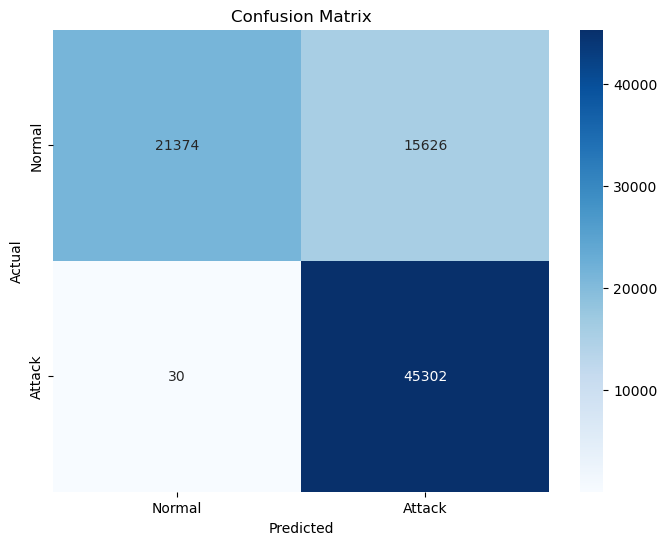

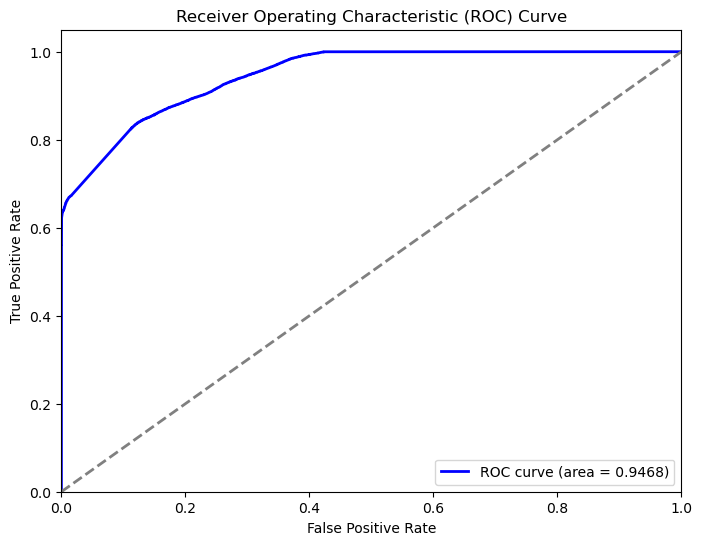

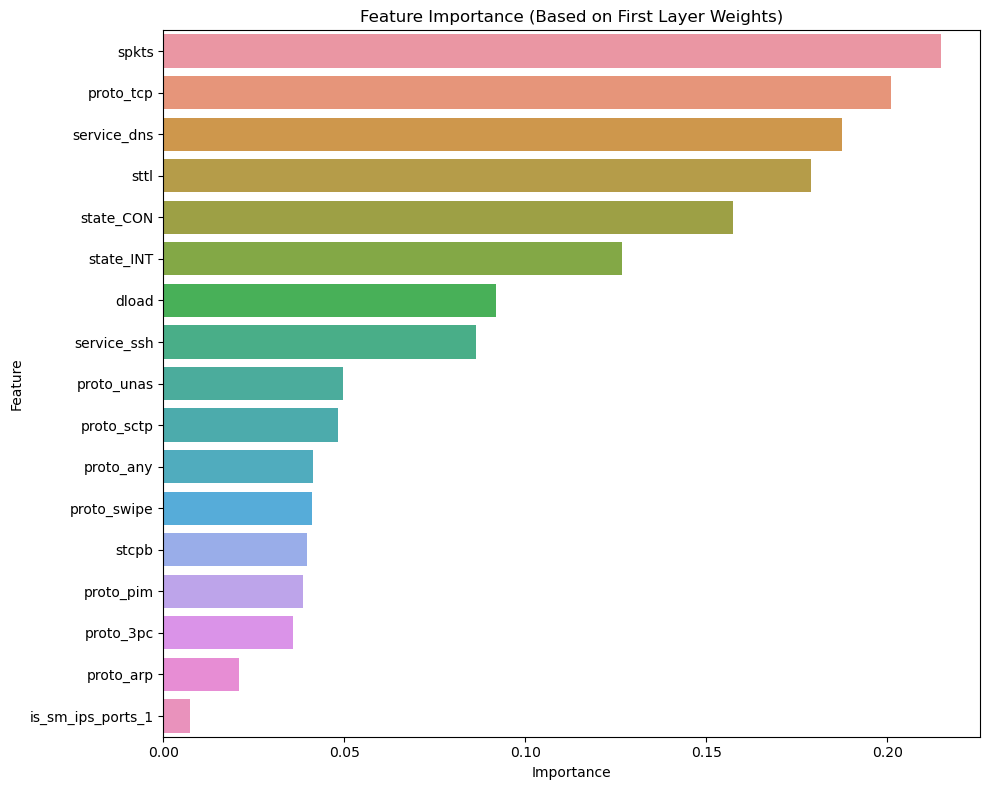

Test F1 Score: 0.8527
Test Accuracy: 0.8098


['best_neural_network_model.pkl']

In [12]:
best_model, evaluation_metrics = train_and_evaluate_best_model(
    train_data=train_data,
    test_data=test_data,
    best_features=best_features,
    best_params=best_params,
    random_state=42
)

# You can access individual metrics
print(f"Test F1 Score: {evaluation_metrics['f1_score']:.4f}")
print(f"Test Accuracy: {evaluation_metrics['accuracy']:.4f}")

# Save the model if needed
import joblib
joblib.dump(best_model, 'best_neural_network_model.pkl')